# Dacon 고객 대출등급 분류 해커톤

## Introduction

- 데이터 불러오기
- 데이터 유효성 검사 및 metadata table 정리하기
- 데이터파악하기
    - 기술 통계량
    - EDA
        - 종속변수 확인
        - 이상치 확인
        - 분포 확인
            - Continuous Data
            - Descrete Data
            - Nominal Data
            - Ordinal Data
        - 상관 분석
        - Insight 정리
- 데이터 전처리
    - 오류 데이터 처리
    - 범주형 데이터에서 카디널리티가 다른 컬럼 확인하고 처리
- Feature Engineering
- Modeling
    - Model Selection
- 모델 평가
- Submission

In [1]:
# library import

# 기본적인 라이브러리
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 통계 라이브러리
import scipy.stats as st

# 추가적인 작업
import missingno as msno
import warnings
warnings.filterwarnings('ignore')

### 데이터 불러오기

In [2]:
# load data

path = '/Users/kengohirano/Desktop/Dacon/Dacon_competiton/2024.01.15/data/open/'

orig = pd.read_csv(path + 'train.csv')
train = pd.read_csv(path + 'train.csv')
test = pd.read_csv(path + 'test.csv')

In [3]:
# view data

train.head(3)

,ID,대출금액,대출기간,근로기간,주택소유상태,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수,대출등급
0,TRAIN_00000,12480000,36 months,6 years,RENT,72000000,18.90,15,부채 통합,0,0,0.0,0.0,0.0,C
1,TRAIN_00001,14400000,60 months,10+ years,MORTGAGE,130800000,22.33,21,주택 개선,0,373572,234060.0,0.0,0.0,B
2,TRAIN_00002,12000000,36 months,5 years,MORTGAGE,96000000,8.60,14,부채 통합,0,928644,151944.0,0.0,0.0,A


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96294 entries, 0 to 96293
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ID            96294 non-null  object 
 1   대출금액          96294 non-null  int64  
 2   대출기간          96294 non-null  object 
 3   근로기간          96294 non-null  object 
 4   주택소유상태        96294 non-null  object 
 5   연간소득          96294 non-null  int64  
 6   부채_대비_소득_비율   96294 non-null  float64
 7   총계좌수          96294 non-null  int64  
 8   대출목적          96294 non-null  object 
 9   최근_2년간_연체_횟수  96294 non-null  int64  
 10  총상환원금         96294 non-null  int64  
 11  총상환이자         96294 non-null  float64
 12  총연체금액         96294 non-null  float64
 13  연체계좌수         96294 non-null  float64
 14  대출등급          96294 non-null  object 
dtypes: float64(4), int64(5), object(6)
memory usage: 11.0+ MB


### 데이터 유효성 검사 및 metadata table 정리

In [5]:
# 유효성 검사 함수

def availiability(data):
    
    dtypes = data.dtypes
    nunique = data.nunique()
    is_na = data.isna().sum()

    table = pd.concat([dtypes , nunique , is_na] , axis = 1)
    table.columns = ['dtype' , 'nunique' , 'NA']

    return table.reset_index()

In [6]:
# 유효성 검사

# 학습데이터
availiability(train).to_csv(path + 'train_aval_table.csv' , index = False)

In [7]:
availiability(test).to_csv(path + 'test_aval_table.csv' , index = False)

In [8]:
# make metadata table

continuous_data = ['대출금액' , '연간소득' , '부채_대비_소득_비율' , '총상환원금' , '총상환이자' , '총연체금액']
descrete_data = ['총계좌수' , '최근_2년간_연체_횟수' , '연체계좌수']
ordinal_data = ['대출기간' , '근로기간']
nominal_data = ['주택소유상태' , '대출목적']

metadata = pd.DataFrame(index = train.columns , columns = ['DataType' , 'NA'])

# 데이터 채우기

# NA 채우기

for col in train.columns:
    if train[col].isna().sum() > 1:
        metadata.loc[col]['NA'] = True
    else:
        metadata.loc[col]['NA'] = False

# DataType 채우기

for col in train.columns:
    if col in continuous_data:
        metadata.loc[col]['DataType'] = 'Continuous'
    elif col in descrete_data:
        metadata.loc[col]['DataType'] = 'Descrete'
    elif col in ordinal_data:
        metadata.loc[col]['DataType'] = 'Ordinal'
    elif col in nominal_data:
        metadata.loc[col]['DataType'] = 'Nominal'

metadata.loc['ID']['DataType'] = 'PK'
metadata.loc['대출등급']['DataType'] = 'Target'

In [9]:
metadata.to_csv(path + 'metadata.csv')

### 데이터 파악하기

#### 기술통계량

In [19]:
# 기술통계량

data = train.select_dtypes(['int' , 'float'])

data.describe().style.background_gradient(cmap = 'summer_r')

,대출금액,연간소득,부채_대비_소득_비율,총계좌수,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수
count,96294.000000,96294.000000,96294.000000,96294.000000,96294.000000,96294.000000,96294.000000,96294.000000,96294.000000
mean,18303998.068415,93926724.677799,19.379590,25.304827,0.345681,822503.486199,428228.247617,54.380584,0.005805
std,10329075.610873,99568708.176833,33.569559,12.088566,0.919119,1027745.264004,440211.075836,1414.769218,0.079966
min,1200000.000000,0.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,10200000.000000,57600000.000000,12.650000,17.000000,0.000000,307572.000000,134616.000000,0.000000,0.000000
50%,16800000.000000,78000000.000000,18.740000,24.000000,0.000000,597696.000000,287004.000000,0.000000,0.000000
75%,24000000.000000,112800000.000000,25.540000,32.000000,0.000000,1055076.000000,570216.000000,0.000000,0.000000
max,42000000.000000,10800000000.000000,9999.000000,169.000000,30.000000,41955936.000000,5653416.000000,75768.000000,4.000000


In [20]:
data = test.select_dtypes(['int' , 'float'])

data.describe().style.background_gradient(cmap = 'summer_r')

,대출금액,연간소득,부채_대비_소득_비율,총계좌수,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수
count,64197.000000,64197.000000,64197.000000,64197.000000,64197.000000,64197.000000,64197.000000,64197.000000,64197.000000
mean,18296295.153979,94463776.395159,19.433747,25.295310,0.342882,823141.239871,432456.175148,50.313192,0.005499
std,10385922.135301,111707085.163632,40.375816,12.021127,0.901277,988016.065321,447279.719113,1396.384546,0.080020
min,1200000.000000,0.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,10080000.000000,57598800.000000,12.630000,17.000000,0.000000,308184.000000,134352.000000,0.000000,0.000000
50%,16800000.000000,78000000.000000,18.770000,24.000000,0.000000,598680.000000,287568.000000,0.000000,0.000000
75%,24000000.000000,112800000.000000,25.560000,32.000000,0.000000,1061508.000000,577416.000000,0.000000,0.000000
max,42000000.000000,10447898400.000000,9999.000000,135.000000,15.000000,40497600.000000,5645688.000000,108240.000000,4.000000


#### EDA

##### 종속변수 확인

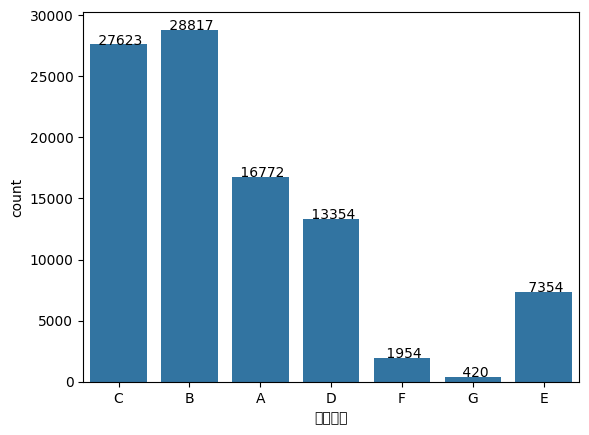

In [28]:
data = train['대출등급']

g = sns.countplot(
    x = data
)

# 텍스트 표시
for p in g.patches:
    g.text(
        p.get_x() + (p.get_width() / 2) ,
        p.get_y() + p.get_height() ,
        f"{p.get_height() : .0f}" ,
        ha = 'center'
    )